In [37]:
import keras
from keras import applications
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPool2D, Dropout, Dense, LSTM, GRU
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import History 
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from keras import models
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
import cv2
import time
import glob, os 
from skimage import io, transform
import json
import datetime
from tqdm import tqdm_notebook
import re
import hw2

You can find all the code and models [here](https://github.com/tnorlund/AdvMachineLearningHW2).

# Problem 1

In order to download the dataset, you need a kaggle account. With this, you can download the data set here [here](https://www.kaggle.com/ivanfel/honey-bee-pollen).

## Reading the Data

After saving all the pictures of the bees to an `/images` directory in the same directory as this one, we can create a "pd.DataFrame()" that will hold the image locations and their target: has pollen or does not have pollen.

In [48]:
path="images/"
imlist= glob.glob(os.path.join(path, '*.jpg'))
df = pd.DataFrame(
    {
        "File":[file.split("/")[1] for file in imlist],
        "Target":[1 if f.split("/")[-1][0] == 'P' else 0 for f in imlist]
    }
)

Now we can use a function to read the images and shape them into the necessary geometry for the model.

In [49]:
def read_images(df):
    X = []
    for index, row in df.iterrows():
        image = io.imread(os.path.join(path, row["File"]))
        image = transform.resize(image, (300,180), mode='constant')
        X.append(image)
    X = np.array(X)
    Y = df["Target"]
    return np.array(X), df["Target"]

## Partitioning the Data

Here, we set 70% of the data for training, 15% for validation, and the last 15% for testing the data.

In [50]:
train_ratio = 0.5
val_ration = 0.25

train_portion = round(df.shape[0] * train_ratio)
validation_portion = round(df.shape[0] * val_ration)

train_df = df.loc[0:train_portion]
val_df = df.loc[train_portion:train_portion+validation_portion]
test_df = df.loc[train_portion+validation_portion:]

In [51]:
train_x, train_y = read_images(train_df)
val_x, val_y = read_images(val_df)
test_x, test_y = read_images(test_df)

With the images loaded and labeled, we can look at the shape of the data and target of the model.

Here, we see that we have 714 images that are RGB. 

Now lets look at an example from the dataset.

In [ ]:
fig, axes = plt.subplots(1,2)
k=0
plt.sca(axes[0])
plt.imshow(train_x[train_df[train_df["Target"]==1].index.tolist()[0]])
plt.title('Has Pollen')

k=400
plt.sca(axes[1])
plt.imshow(train_x[train_df[train_df["Target"]==0].index.tolist()[0]])
plt.title('No Pollen');

With this, we can compile a model composed of the convolution layers. 

In [ ]:
verbose = 0
# input
input_layer = Input(shape=(300, 180, 3))

# conv layers
conv_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv_layer1 = MaxPool2D( (2, 2), padding='same')(conv_layer1)

conv_layer2 = Conv2D(64, (3, 3), activation='relu')(conv_layer1)
conv_layer2 = MaxPool2D( (2, 2), padding='same')(conv_layer2)

conv_layer3 = Conv2D(128, (3, 3), activation='relu')(conv_layer2)
conv_layer3 = Conv2D(128, (3, 3), activation='relu')(conv_layer3)
conv_layer3 = MaxPool2D( (2, 2), padding='same')(conv_layer3)

conv_layer4 = Conv2D(256, (3, 3), activation='relu')(conv_layer3)
conv_layer4 = Conv2D(256, (3, 3), activation='relu')(conv_layer4)
conv_layer4 = MaxPool2D( (2, 2), padding='same')(conv_layer4)

# flatten and dense layers
flatten_layer = Flatten()(conv_layer3)
dense_layer   = Dense(512, activation='relu')(flatten_layer)

# output
output_layer  = Dense(1, activation='sigmoid')(dense_layer)

model = Model(input_layer, output_layer)
model.compile(
    optimizer=RMSprop(lr=1e-4), 
    loss='binary_crossentropy',
    metrics=['accuracy'])
if verbose==1:
    print(model_1.summary())

In [ ]:
epochs = 10
batch_size = 16
history = model.fit(
    train_x, 
    train_y,
    validation_data=(val_x, val_y),
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1
)

In [ ]:
with open("history_1.json") as fp:
    history = json.load(fp)

In [ ]:
model.save_weights("conv_model.h5")
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation Acc')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [ ]:
test_loss, test_acc = model_1.evaluate(x_test, y_test, steps=10)
print('The final test accuracy: ',test_acc)

## Data Augmentation

Use data augmentation to generate more training data from your existing training samples. Also add a Dropout layer to your model, right before the densely connected classifier.

In [ ]:
# input
input_layer = Input(shape=(300, 180, 3))

# conv layers
conv_layer1   = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv_layer1   = MaxPool2D( (2, 2), padding='same')(conv_layer1)

conv_layer2   = Conv2D(64, (3, 3), activation='relu')(conv_layer1)
conv_layer2   = MaxPool2D( (2, 2), padding='same')(conv_layer2)

conv_layer3   = Conv2D(128, (3, 3), activation='relu')(conv_layer2)
conv_layer3   = Conv2D(128, (3, 3), activation='relu')(conv_layer3)
conv_layer3   = MaxPool2D( (2, 2), padding='same')(conv_layer3)

conv_layer4   = Conv2D(256, (3, 3), activation='relu')(conv_layer3)
conv_layer4   = Conv2D(256, (3, 3), activation='relu')(conv_layer4)
conv_layer4   = MaxPool2D( (2, 2), padding='same')(conv_layer4)

# flatten and dense layers
flatten_layer = Flatten()(conv_layer3)
flatten_layer = Dropout(0.5)(flatten_layer)
dense_layer   = Dense(512, activation='relu')(flatten_layer)

# output
output_layer  = Dense(1, activation='sigmoid')(dense_layer)

model_2 = Model(input_layer, output_layer)
model_2.compile(
    optimizer=RMSprop(lr=1e-4), 
    loss='binary_crossentropy',
    metrics=['accuracy'])
if verbose==1:
    print(model_2.summary())

In [ ]:
df['Target'] = df['Target'].astype(str)
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
train_generator = datagen.flow_from_dataframe(
    dataframe=df, 
    directory=path,
    x_col="File",
    y_col="Target",
    class_mode="categorical",
    target_size=(32,32),
    batch_size=32
)

In [ ]:
batch_size = 16
verbose = 0
gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
history = model.fit_generator(
    gen.flow(
        train_x, 
        train_y, 
        batch_size=batch_size
    ),
    validation_data=ImageDataGenerator().flow(
        val_x, 
        val_y, 
        batch_size=batch_size
    ),
    steps_per_epoch=2000 / batch_size,
    epochs=10,
    verbose=1
)
model.save_weights("augmented_conv_model.h5")

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation Acc')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [ ]:
model_2.save_weights("part1-2.h5")

In [ ]:
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation Acc')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [ ]:
test_loss, test_acc = model_2.evaluate(x_test, y_test, steps=10)
print('The final test accuracy: ',test_acc)

## VGG16


In [42]:
img_width = 300
img_height = 180
model_3 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [43]:
# Freeze the first few layers of the VGG16 model to use the original weights and not change them
for layer in model_3.layers[:30]:
    layer.trainable = False

In [44]:
#Adding custom Layers 
x = model_3.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

In [45]:
# creating the final model 
model_3 = Model(input = model_3.input, output = predictions)

/opt/homebrew/Cellar/python36/3.6.2+_254.20170915/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [46]:
model_3.compile(
    optimizer=RMSprop(lr=1e-4), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
epochs = 10
batch_size = 25
history = model_3.fit(
    train_x, 
    train_y,
    validation_data=(val_x, val_y),
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1
)
model_3.save_weights('vgg16_model.h5')
with open("vgg16.json", 'w') as outfile:
    json.dump(history.history, outfile)

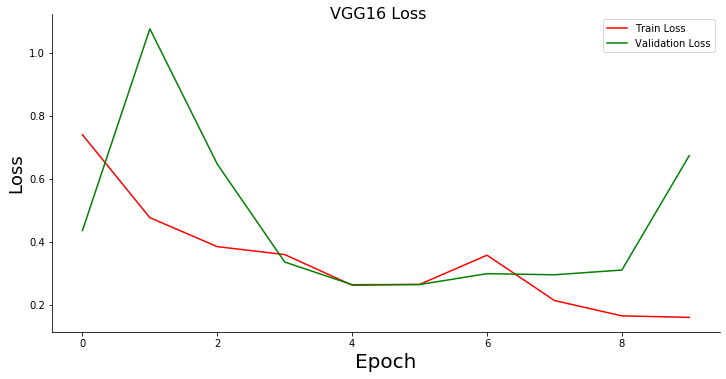

In [55]:
with open("vgg16.json", "r") as json_file:
    history = json.load(json_file)
fig, ax = plt.subplots(figsize=(10, 5))
fig.tight_layout()
ax.plot(history["loss"], c="red", label="Train Loss")
ax.plot(history["val_loss"], c="green", label="Validation Loss")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=18)
fig.suptitle('VGG16 Loss', fontsize=16)
plt.legend()
plt.show()

## Problem 2

For this problem you use the data in “admData.csv” on Canvas. This file contains the accumulative number of admitted students to a certain program with 5 annual start dates.

The data has seasonal behavior: the accumulative number of admissions is monotonically increasing during the interval between 2 start dates and then it resets once a new term starts.

The objective of the problem is to predict the accumulative number of admissions 7, 14, 21, 28, 35, 42, 49, 56, 63, and 70 days from the current date.

i.e. on any given day, you need to forecast what the accumulative number of admissions will be in 1 week, 2 weeks, ... 10 weeks from that day.
You need to use 70% of the data for training, 15% for validation, and 15% (the most recent) for test.

---

## Reading the Data

So here, we separate the year, month, and day of the date.

In [60]:
df = pd.read_csv(
    filepath_or_buffer="admData.csv"
)
df["Month"] = df['InquiryDate'].astype(str).str.split("/").str[0].astype(int)
df["Day"] = df['InquiryDate'].astype(str).str.split("/").str[1].astype(int)
df["Year"] = df['InquiryDate'].astype(str).str.split("/").str[2].astype(int)
dates = df['InquiryDate'].tolist()
df['InquiryDate'] = pd.to_datetime(df['InquiryDate'])
df.head()

,InquiryDate,DailyAdmission,Month,Day,Year
0,2017-08-22,41,8,22,2017
1,2017-08-23,47,8,23,2017
2,2017-08-24,56,8,24,2017
3,2017-08-25,63,8,25,2017
4,2017-08-26,70,8,26,2017


## Data Exploration

There are some dramatic swings in the dataset:

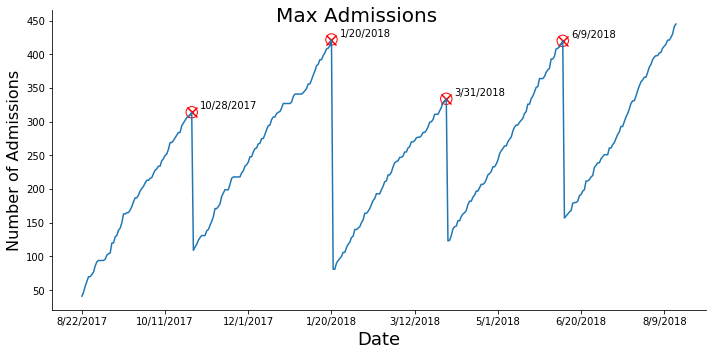

In [61]:
peaks = [66, 150, 219, 289]

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(range(df["DailyAdmission"].shape[0]), df["DailyAdmission"])
plt.scatter(df.iloc[peaks, :].index.tolist(), df.iloc[peaks, :]["DailyAdmission"].tolist(), s=100, c="red", marker="x")
plt.scatter(df.iloc[peaks, :].index.tolist(), df.iloc[peaks, :]["DailyAdmission"].tolist(), s=130, facecolors='none', edgecolors='r')
[plt.text(_labels[0]+5, _labels[1]+5, _labels[2], fontsize=10) for _labels in list(zip(
    df.iloc[peaks, :].index.tolist(), 
    df.iloc[peaks, :]["DailyAdmission"].tolist(), 
    (df.iloc[peaks, :]["Month"].astype(str) + "/" + df.iloc[peaks, :]["Day"].astype(str) + "/" + df.iloc[peaks, :]["Year"].astype(str)).tolist()
))]
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
_tmp = [labels[0]]
labels = labels[1:]
_tmp.extend([dates[int(label)] for label in labels if not label[0] == "−" and int(label) < len(dates)])
ax.set_xticklabels(_tmp)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
fig.suptitle('Max Admissions', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of Admissions', fontsize=16)
fig.tight_layout()
plt.show()

We can see that there are definite peaks in the time series. But we need to slow down and use our great discerning skills. If we look at the dates given to us, we can clearly see that each of these dates lands on a Saturday. While the first and last recordings are 8/22/2017 and 8/16/2018 respectively, we can assume that the next peak will be the Saturday between these two dates minus the year. In other words, the most likely time the next peak will be, will be the Saturday in that window, 8/18/2018.
 1. 1/20/2018
 2. 3/31/2018
 3. 6/9/2018
 4. 8/18/2017
 5. 10/28/2017
 
So if we identify these as periods or seasons, we can simplify this graph. Let's name our seasons:
1. Winter
2. Spring
3. Summer
4. Fall
5. End-Of-Fall

With these defined, we can compare the different rates of growth per season with the data we were given.

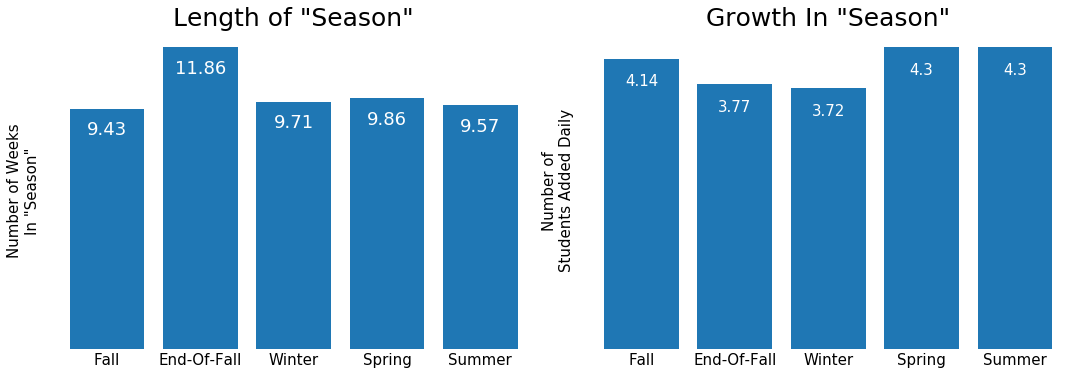

In [62]:
coords = []
for index, row in df.iloc[[0, peaks[0]], :].iterrows():
    coords.append((index, row["DailyAdmission"]))
for ii in range(1, len(peaks)):
    for index, row in df.iloc[[peaks[ii-1]+1, peaks[ii]], :].iterrows():
        coords.append((index, row["DailyAdmission"]))
slopes = []
for ii in range(0, len(coords), 2):
    start, stop = coords[ii:ii+2]
    slopes.append(float(stop[1] - start[1])/float(stop[0] - start[0]))
xs = df.iloc[[coords[-1][0]+1, df.shape[0]-1],:]["DailyAdmission"].index.tolist()
ys = df.iloc[[coords[-1][0]+1, df.shape[0]-1],:]["DailyAdmission"].values.tolist()
slopes.append(float(ys[1]-ys[0])/float(xs[1]-xs[0]))
runs = []
for ii in range(0, len(coords), 2):
    start, stop = coords[ii:ii+2]
    runs.append((stop[0] - start[0])/7)
xs = df.iloc[[coords[-1][0]+1, df.shape[0]-1],:]["DailyAdmission"].index.tolist()
runs.append((xs[1]-xs[0])/7)
fig, (a0, a1) = plt.subplots(1, 2, figsize=(15, 5))
x_labels = ["", "Fall", "End-Of-Fall", "Winter", "Spring", "Summer"]
fig.tight_layout()
a0.bar(np.arange(len(runs)), runs, align="center")
for rect, label in zip(a0.patches, [str(round(run,2)) for run in runs]):
    height = rect.get_height()
    a0.text(rect.get_x() + rect.get_width() / 2, height-(max(runs)*0.1), label,
            ha='center', va='bottom', fontsize=18, color="white")
a0.set_ylabel("Number of Weeks\nIn \"Season\"", fontsize=15)
a0.set_xticklabels(x_labels, fontsize = 15, rotation=0)
a0.set_yticklabels([])
a0.spines['right'].set_visible(False)
a0.spines['top'].set_visible(False)
a0.spines['left'].set_visible(False)
a0.spines['bottom'].set_visible(False)
a0.tick_params(axis=u'both', which=u'both',length=0)
a0.set_title("Length of \"Season\"", fontsize=25)
a1.bar(np.arange(len(slopes)), slopes, align="center")
for rect, label in zip(a1.patches, [str(round(slope, 2)) for slope in slopes]):
    height = rect.get_height()
    a1.text(rect.get_x() + rect.get_width() / 2, height-(max(slopes)*0.1), label,
            ha='center', va='bottom', fontsize=15, color="white")
a1.set_ylabel("Number of\nStudents Added Daily", fontsize=15)
a1.set_xticklabels(x_labels, fontsize = 15, rotation=0)
a1.set_yticklabels([])
a1.spines['right'].set_visible(False)
a1.spines['top'].set_visible(False)
a1.spines['left'].set_visible(False)
a1.spines['bottom'].set_visible(False)
a1.tick_params(axis=u'both', which=u'both',length=0)
a1.set_title("Growth In \"Season\"", fontsize=25)
plt.show()

Voilà, we have some solid information about how the different times of the year affect the number of students that are admitted. Here, we see that the "Fall," "Spring," and "Summer" "Seasons" are the highest performing. In these "Seasons," more students are admitted on a daily basis. Also, we see that the length of the seasons are fairly consistent besides the largest, "End-Of-Fall." Again, let's use our great discerning skills. This season holds the holidays, Thanksgiving, Christmas, and New Years. Most people do not work for this period of time. If we take 2 weeks off for the holidays:

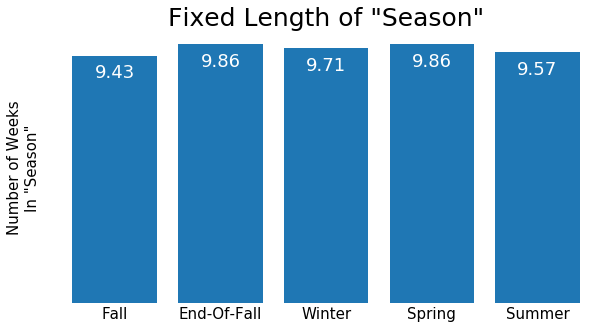

In [63]:
runs[1] = runs[1] - 2
[runs[0]].extend(runs[1:])
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(np.arange(len(runs)), runs, align="center")
for rect, label in zip(ax.patches, [str(round(run,2)) for run in runs]):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height-(max(runs)*0.1), label,
            ha='center', va='bottom', fontsize=18, color="white")
ax.set_ylabel("Number of Weeks\nIn \"Season\"", fontsize=15)
ax.set_xticklabels(x_labels, fontsize = 15, rotation=0)
ax.set_yticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_title("Fixed Length of \"Season\"", fontsize=25)
plt.show()

Well that's something! The dataset has an average of 9.6 weeks between peaks with a standard deviation of 0.16 weeks. From this information, we can say:
 - Each peak will be on a Saturday. It's the end of the week, "Am I right?"
 - Each "Season" is 10 weeks besides the "End-Of-Fall" which has an additional 2 weeks. This ensures that indexing the data by "Season" fits with the 52-week periodicity of a year.
 - The "End-Of-Fall" and "Winter" "Seasons" have the lowest growth of students admitted daily.
 
We've got the amount of time that each "Season" is, but when do each of them start? Since each one ends on a Saturday, let's say that each one *needs* to start on a Sunday. We can also say that these "Seasons" will be consistent in length. With this, we can determine our "phase shift" of some function of the number of daily admissions over time.

In [64]:
def SetSeasonality(df):
    datetime_columns = df.select_dtypes(np.datetime64).columns.tolist()
    if len(datetime_columns) > 1:
        print("Cannot set seasons because more that one of the columns are set as datetime")
        return None
    if len(datetime_columns) == 0:
        print("Cannot set seasons because no columns are set as datetime")
        return None
    else:
        datetime_column = datetime_columns[0]
        
    df["DayOfWeek"] = df[datetime_column].dt.dayofweek
    df["WeekNumber"] = df[datetime_column].dt.week
    df["Season"] = np.nan
    df.loc[
        (df["WeekNumber"]>43) | 
        (df["WeekNumber"]<3)  | 
        ((df["WeekNumber"]<=3) & (df["DayOfWeek"]<6)) | 
        ((df["WeekNumber"]==43) & (df["DayOfWeek"]==6)),
    ["Season"]] = 4
    df.loc[
        ((df["WeekNumber"]>3) & (df["WeekNumber"]<13)) | 
        ((df["WeekNumber"]==3) & (df["DayOfWeek"]==6)) |
        ((df["WeekNumber"]==13) & (df["DayOfWeek"]<6))
    ,["Season"]] = 0
    df.loc[
        ((df["WeekNumber"]>13) & (df["WeekNumber"]<23)) | 
        ((df["WeekNumber"]==13) & (df["DayOfWeek"]==6)) |
        ((df["WeekNumber"]==23) & (df["DayOfWeek"]<6))
    ,["Season"]] = 1
    df.loc[
        ((df["WeekNumber"]>23) & (df["WeekNumber"]<33)) | 
        ((df["WeekNumber"]==23) & (df["DayOfWeek"]==6)) |
        ((df["WeekNumber"]==33) & (df["DayOfWeek"]<6))
    ,["Season"]] = 2
    df.loc[
        ((df["WeekNumber"]>33) & (df["WeekNumber"]<43)) | 
        ((df["WeekNumber"]==33) & (df["DayOfWeek"]==6)) |
        ((df["WeekNumber"]==43) & (df["DayOfWeek"]<6))
    ,["Season"]] = 3
    return df

SetSeasonality(df).head()

,InquiryDate,DailyAdmission,Month,Day,Year,DayOfWeek,WeekNumber,Season
0,2017-08-22,41,8,22,2017,1,34,3.0
1,2017-08-23,47,8,23,2017,2,34,3.0
2,2017-08-24,56,8,24,2017,3,34,3.0
3,2017-08-25,63,8,25,2017,4,34,3.0
4,2017-08-26,70,8,26,2017,5,34,3.0


## Feature Extraction

Based on a number of days to look back, we can add additional columns based on the previous day(s) "Daily Admission." We must note that the larger the number of the days looking back, the smaller the dataset.

In [65]:
week_of_days = list(range(1, 8))

def get_features_by_days(df, days):
    days.sort()
    _tmp_df = df.copy(deep=True)
    for num_days_back in days:
        _tmp = [None] * num_days_back
        _tmp.extend(df.iloc[:-num_days_back, :]["DailyAdmission"].values.tolist())
        _tmp_df["{}DaysBack".format(num_days_back)] = _tmp
    _tmp_df = _tmp_df.dropna()
    cols = _tmp_df.columns.tolist()
    return _tmp_df[cols[1:] + [cols[0]]]
get_features_by_days(df, week_of_days).head()

,DailyAdmission,Month,Day,Year,DayOfWeek,WeekNumber,Season,1DaysBack,2DaysBack,3DaysBack,4DaysBack,5DaysBack,6DaysBack,7DaysBack,InquiryDate
7,77,8,29,2017,1,35,3.0,73.0,70.0,70.0,63.0,56.0,47.0,41.0,2017-08-29
8,86,8,30,2017,2,35,3.0,77.0,73.0,70.0,70.0,63.0,56.0,47.0,2017-08-30
9,92,8,31,2017,3,35,3.0,86.0,77.0,73.0,70.0,70.0,63.0,56.0,2017-08-31
10,94,9,1,2017,4,35,3.0,92.0,86.0,77.0,73.0,70.0,70.0,63.0,2017-09-01
11,94,9,2,2017,5,35,3.0,94.0,92.0,86.0,77.0,73.0,70.0,70.0,2017-09-02


After defining the "Seasons" found in the data, we can count the number of weeks past the last change of the "Season."

In [66]:
def set_weeks_after_peak(df):
    _tmp_df = df.copy(deep=True)
    _tmp_df["WeeksAfterPeak"] = np.nan
    for season_number in range(0,5):
        first_index = _tmp_df.loc[_tmp_df["Season"]==season_number].index.tolist()[0]
        week_breaks = list(range(0, _tmp_df.loc[df["Season"]==season_number].shape[0], 7))
        for ii in range(1, len(week_breaks)):
            _tmp_df.loc[week_breaks[ii-1]+first_index:week_breaks[ii]+first_index, ["WeeksAfterPeak"]] = week_breaks[ii-1]/7
        if season_number == 4:
            _tmp_df.loc[week_breaks[-1] + first_index:_tmp_df.loc[df["Season"]==season_number].shape[0] + first_index, ["WeeksAfterPeak"]] = 11
        else:
            _tmp_df.loc[week_breaks[-1] + first_index:_tmp_df.loc[df["Season"]==season_number].shape[0] + first_index, ["WeeksAfterPeak"]] = 9
    return _tmp_df
set_weeks_after_peak(df).tail()

,InquiryDate,DailyAdmission,Month,Day,Year,DayOfWeek,WeekNumber,Season,WeeksAfterPeak
353,2018-08-12,421,8,12,2018,6,32,2.0,9.0
354,2018-08-13,425,8,13,2018,0,33,2.0,9.0
355,2018-08-14,430,8,14,2018,1,33,2.0,9.0
356,2018-08-15,441,8,15,2018,2,33,2.0,9.0
357,2018-08-16,445,8,16,2018,3,33,2.0,9.0


## Partitioning the Data

Here, we set 70% of the data for training, 15% for validation, and the last 15% for testing the data.

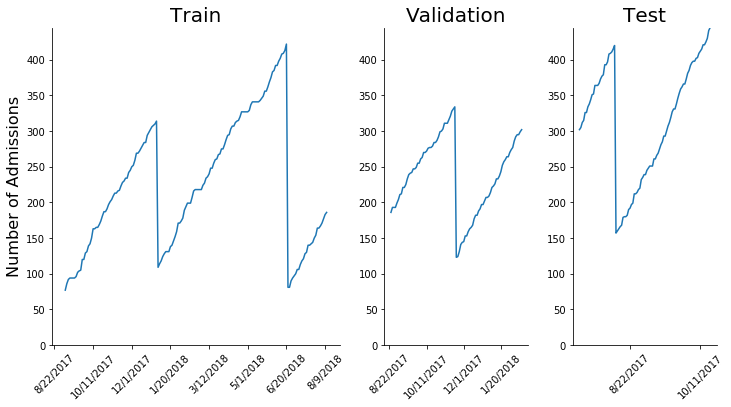

In [67]:
train_ratio = 0.5
val_ration = 0.25
df = get_features_by_days(df, week_of_days)
df = set_weeks_after_peak(df)
if "InquiryDate" in df.columns:
    del df["InquiryDate"]
train_portion = round(df.shape[0] * train_ratio)
validation_portion = round(df.shape[0] * val_ration)

train_df = df.loc[0:train_portion]
val_df = df.loc[train_portion:train_portion+validation_portion]
test_df = df.loc[train_portion+validation_portion:]


fig, axs = plt.subplots(
    1, 
    3, 
    gridspec_kw={
        'width_ratios': [
            int(train_ratio*100), 
            int(val_ration*100), 
            int(-(train_ratio+val_ration-1)*100)
        ]
    },
    figsize=(10, 5)
)
fig.tight_layout()

axs[0].plot(train_df["DailyAdmission"])
axs[0].set_title("Train", fontsize=20)
axs[0].set_ylabel('Number of Admissions', fontsize=16)
axs[1].plot(val_df["DailyAdmission"])
axs[1].set_title("Validation", fontsize=20)
axs[2].plot(test_df["DailyAdmission"])
axs[2].set_title("Test", fontsize=20)

for ax in axs:
    ax.set_ylim([0,df["DailyAdmission"].max()])
    locs, labels = plt.xticks()
    _tmp.extend([dates[int(loc)] for loc in ax.get_xticks() if loc > 0 and int(loc) < len(dates)])
    ax.set_xticklabels(_tmp, rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
plt.show()

## Normalizing the Data

With added features comes additional steps in normalizing the data. We have a few columns to look after:
1. DailyAdmission
2. Month
3. Day
4. Year
5. DayOfWeek
6. WeekNumber
7. Season
8. WeeksAfterPeak

In order to normalize the data, we can minimum and maximum values in each row to set all of our features to be between 0 and 1. The Month, Day, Year, DayOfWeek, WeekNumber, Season, and WeeksAfterPeak have a specific domain, meaning that their minimums and maximums are constant on any amount of data we are given.

The DailyAdmission will change with the data we are given. Because we will be relying on the training dataset while fitting the model, we can use the minimum and maximum values found in the training dataset to normalize other datasets we will be given.

In [68]:
sc = MinMaxScaler(feature_range=(0,1))
sc.fit(train_df["DailyAdmission"].values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

With `sc`, we can now normalize the train, validation, and test data we partitioned earlier.

In [69]:
def normalize_df(df, sc):
    pd.options.mode.chained_assignment = None 
    _tmp_df = df.copy(deep=True)
    _tmp_df.loc[:, ["DailyAdmission"]] = sc.transform(_tmp_df["DailyAdmission"].values.reshape(-1,1)).flatten()
    for column in [column for column in train_df.columns.tolist() if "DaysBack" in column]:
        _tmp_df.loc[:, [column]] = sc.transform(_tmp_df[column].values.reshape(-1,1)).flatten()
    _tmp_df["Month"] = _tmp_df["Month"]/12
    _tmp_df["Day"] = _tmp_df["Day"]/12
    _tmp_df["Year"] = _tmp_df["Year"]/2018
    _tmp_df["DayOfWeek"] = _tmp_df["DayOfWeek"]/6
    _tmp_df["WeekNumber"] = _tmp_df["WeekNumber"]/52
    _tmp_df["Season"] = _tmp_df["Season"]/4
    _tmp_df["WeeksAfterPeak"] = _tmp_df["WeeksAfterPeak"]/11
    return _tmp_df
norm_train_df = normalize_df(train_df, sc)
norm_val_df = normalize_df(val_df, sc)
norm_test_df = normalize_df(test_df, sc)
norm_df = normalize_df(df, sc)

## Creating Sequences

Here we can use a function to develop sequences to train our model with. Here, we say that with the previous 5 days, get the 7th day from now. This function will allow us to create additional datasets for training purposes.

In [70]:
def create_sequence_df(df, look_back=5, foresight=7):
    X, Y = [], []
    _tmp_df = df.copy(deep=True)
    for i in range(df.shape[0]-look_back-foresight):
        X.append(df.iloc[i:(i+look_back),:].values)
        Y.append(df.iloc[i+look_back+foresight]["DailyAdmission"])
    return np.array(X), np.array(Y)
norm_train_x, norm_train_y = create_sequence_df(norm_train_df)
norm_val_x, norm_val_y = create_sequence_df(norm_val_df)
norm_test_x, norm_test_y = create_sequence_df(norm_test_df)
norm_all_x, norm_all_y = create_sequence_df(norm_df)

## Training - LSTM/GRU

In [14]:
def run_lstm(
    dropout,
    recurrent_dropout,
    batch_size,
    filter_size,
    epochs = 60,
    verbose = 0
):
    output_path = "./model_output/"
    modelname = "LSTM_numEpoch-{}_dropout-{}_recurrentDropout-{}_batchSize-{}_filterSize-{}".format(
        epochs,
        dropout, 
        recurrent_dropout,
        batch_size,
        filter_size
    )
    with open("lstm.json", "r") as json_file:
        model_dict = json.load(json_file)
    if modelname in model_dict.keys():
        return
    print(modelname)
    filepath = output_path + modelname + "_epoch-{epoch:02d}_loss-{loss:.4f}.hdf5"
    input_layer = Input(shape=(norm_train_x.shape[1], norm_train_x.shape[2]))
    lstm_layer = LSTM(
        filter_size,
        dropout=dropout, 
        recurrent_dropout=recurrent_dropout
    )(input_layer)
    output_layer = Dense(
        1, 
        activation="linear"
    )(lstm_layer)
    model = Model(input_layer, output_layer)
    model.compile(
        loss="mae", 
        optimizer="adam" ,
        metrics=["mean_absolute_error"]
    )
    history = model.fit(
        norm_train_x, 
        norm_train_y,
        validation_data=(
            norm_val_x,
            norm_val_y
        ),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        callbacks=[
            ModelCheckpoint(
                filepath,
                monitor="loss",
                verbose=verbose,
                save_best_only=True,
                mode="min"
            )
        ]
    )
    model_dict[modelname] = history.history
    with open("lstm.json", 'w') as outfile:
        json.dump(model_dict, outfile)

In [33]:
def run_gru(
    dropout,
    recurrent_dropout,
    batch_size,
    
    filter_size,
    epochs = 60,
    verbose = 0
):
    output_path = "./model_output/"
    modelname = "GRU_numEpoch-{}_dropout-{}_recurrentDropout-{}_batchSize-{}_filterSize-{}".format(
        epochs,
        dropout, 
        recurrent_dropout,
        batch_size,
        filter_size
    )
    with open("gru.json", "r") as json_file:
        model_dict = json.load(json_file)
    if modelname in model_dict.keys():
        return
    print(modelname)
    filepath = output_path + modelname + "_epoch-{epoch:02d}_loss-{loss:.4f}.hdf5"
    input_layer = Input(shape=(norm_train_x.shape[1], norm_train_x.shape[2]))
    lstm_layer = LSTM(
        filter_size,
        dropout=dropout, 
        recurrent_dropout=recurrent_dropout
    )(input_layer)
    output_layer = Dense(
        1, 
        activation="linear"
    )(lstm_layer)
    model = Model(input_layer, output_layer)
    model.compile(
        loss="mae", 
        optimizer="adam" ,
        metrics=["mean_absolute_error"]
    )
    history = model.fit(
        norm_train_x, 
        norm_train_y,
        validation_data=(
            norm_val_x,
            norm_val_y
        ),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        callbacks=[
            ModelCheckpoint(
                filepath,
                monitor="loss",
                verbose=verbose,
                save_best_only=True,
                mode="min"
            )
        ]
    )
    model_dict[modelname] = history.history
    with open("gru.json", 'w') as outfile:
        json.dump(model_dict, outfile)

In [106]:
for batch_size in range(4, 36, 4):
    for filter_size in range(4, 36, 4):
        for dropout in range(0, 125, 25):
            for recurrent_dropout in range(0, 125, 25):
                run_lstm(
                    dropout=dropout/100,
                    recurrent_dropout=recurrent_dropout/100,
                    batch_size=batch_size,
                    filter_size=filter_size
                )
                run_gru(
                    dropout=dropout/100,
                    recurrent_dropout=recurrent_dropout/100,
                    batch_size=batch_size,
                    filter_size=filter_size
                )

## Results - LSTM/GRU

So after training on a couple computers, we were able to get some valuable information surrounding how the different parameters effect training. Here, we make the assumption that larger batch sizes produce better results.

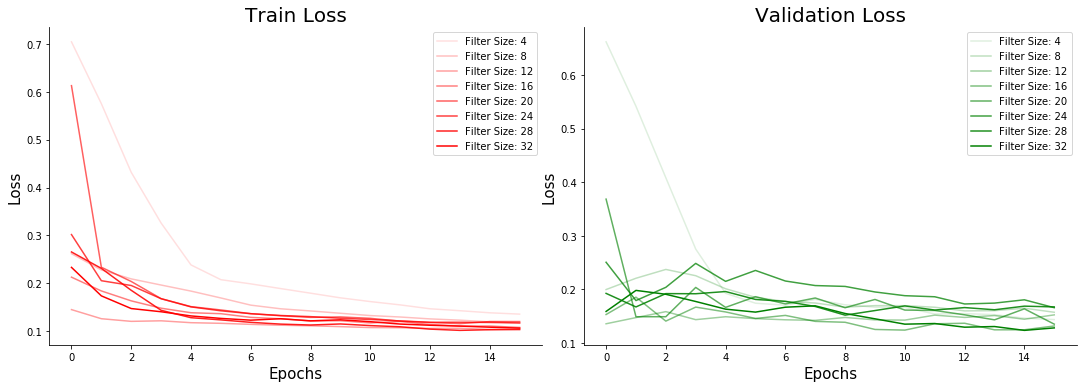

In [23]:
hw2.compare_lstm_filtersize(
    batch_size = 16,
    max_epoch = 15
)

With a larger batch size, we see that the "average" sized filter sizes have the best validation loss.

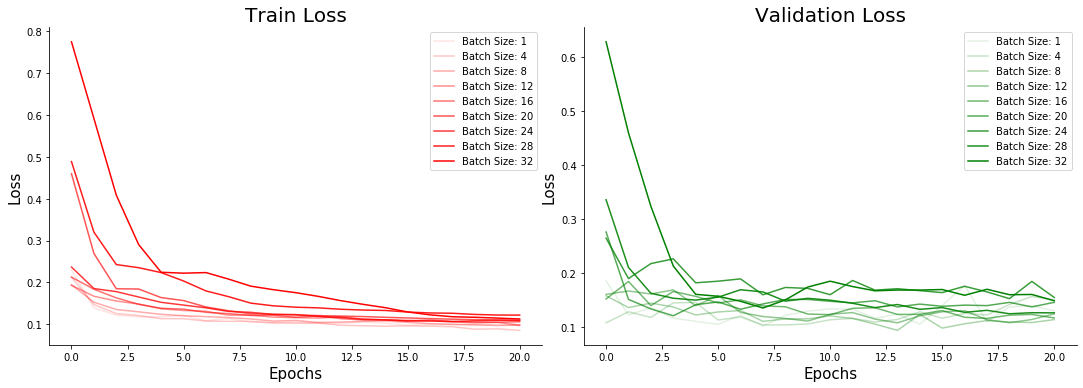

In [24]:
hw2.compare_lstm_batchSize(
    filter_size=16,
    max_epoch=20
)

After choosing the best batch size and filter size, we can compare the model using different dropout values:

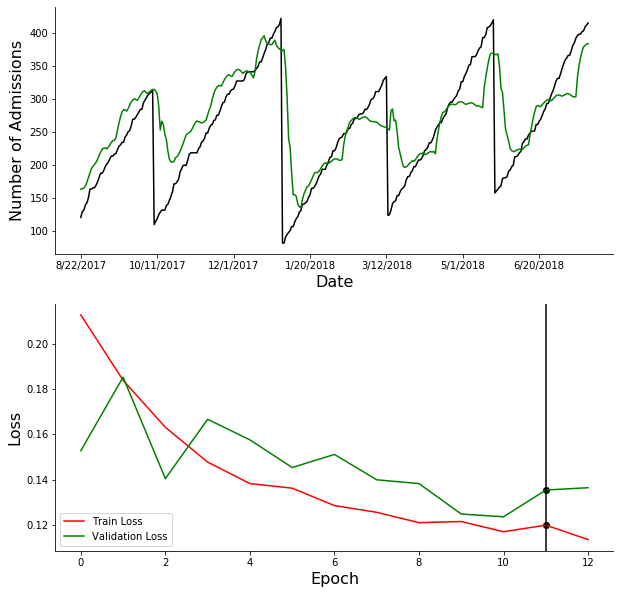

In [40]:
hw2.plot_lstm(
    sc = sc,
    norm_all_x=norm_all_x,
    norm_all_y=norm_all_y,
    dates=dates,
    batch_size = 16,
    filter_size = 16,
    epoch = 11,
    dropout = 0,
    recurrent_dropout = 0,
)

Substituting the LSTM layer with a GRU layer, we can continue with the assumption that the larger batch sizes produce better results:

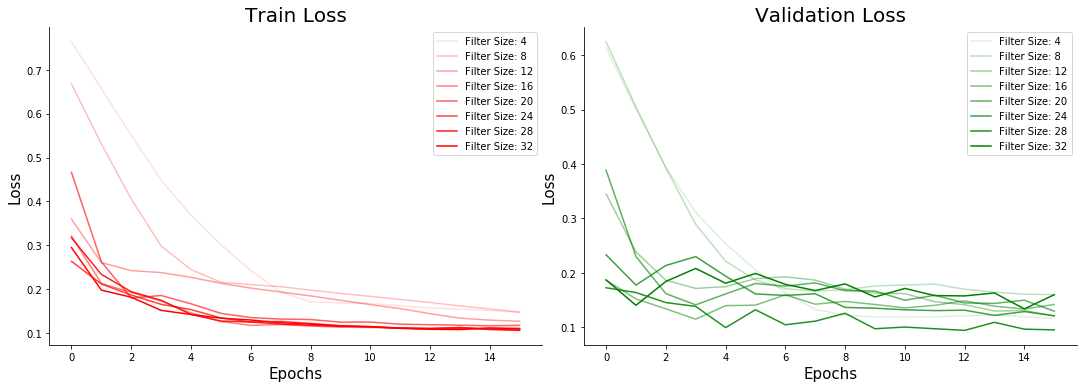

In [41]:
hw2.compare_gru_filtersize(
    batch_size = 24,
    max_epoch = 15
)

Looking at the graphs, the larger filter sizes result in better validation loss over time. 

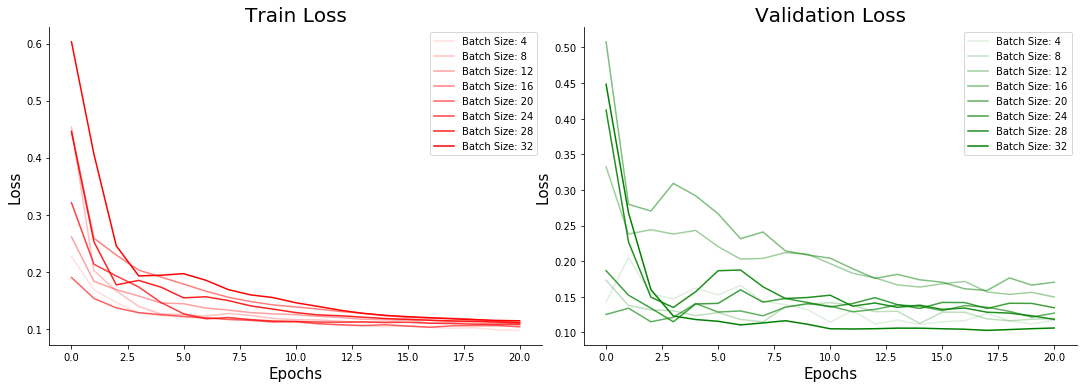

In [42]:
hw2.compare_gru_batchSize(
    filter_size=16,
    max_epoch=20
)

Figuring that larger batch sizes and larger filter sizes produce better results, we can figure which dropout values produce the best results.

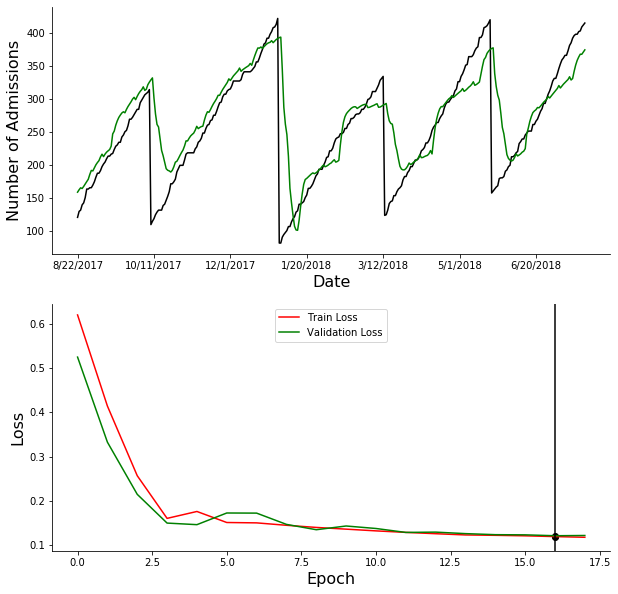

In [43]:
hw2.plot_gru(
    sc = sc,
    norm_all_x=norm_all_x,
    norm_all_y=norm_all_y,
    dates=dates,
    batch_size = 28,
    filter_size = 20,
    epoch = 16,
    dropout = 0,
    recurrent_dropout = 0,
)

## Training - Conv1D

In [18]:
def run_1dconv(
    verbose,
    kernel_size,
    filter_size,
    batch_size,
    epochs
):
    output_path = "./model_output/"
    modelname = "CONV1D_numEpoch-{}_kernelSize-{}_batchSize-{}_filterSize-{}".format(
        epochs,
        kernel_size,
        batch_size,
        filter_size
    )
    with open("conv1d.json", "r") as json_file:
            model_dict = json.load(json_file)
    if modelname in model_dict.keys():
        return
    print(modelname)
    filepath = output_path + modelname + "_epoch-{epoch:02d}_loss-{loss:.4f}.hdf5"
    input_layer = Input(shape=(norm_train_x.shape[1], norm_train_x.shape[2]))
    conv_layer = Conv1D(
        filters=filter_size,
        kernel_size=kernel_size
    )(input_layer)
    pool_layer = MaxPooling1D(kernel_size)(conv_layer)
    flatten_layer = Flatten()(pool_layer)
    output_layer = Dense(
        1, 
        activation="linear"
    )(flatten_layer)
    model = Model(input_layer, output_layer)
    model.compile(
        loss="mae", 
        optimizer="adam" ,
        metrics=["mean_absolute_error"]
    )
    history = model.fit(
        norm_train_x, 
        norm_train_y,
        validation_data=(
            norm_val_x,
            norm_val_y
        ),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose, 
        callbacks=[
            ModelCheckpoint(
                filepath,
                monitor="loss",
                verbose=verbose,
                save_best_only=True,
                mode="min"
            )
        ]
    )
    model_dict[modelname] = history.history
    with open("conv1d.json", 'w') as outfile:
        json.dump(model_dict, outfile)


In [36]:
for kernel_size in range(2, 4):
    for filter_size in range(4, 36, 4):
        for batch_size in range(4, 36, 4):
            run_1dconv(
                verbose = 0,
                kernel_size = kernel_size,
                filter_size = filter_size,
                batch_size = batch_size,
                epochs = 60
            )

## Results - Conv1D

After training the Conv1D model, we can continue to believe that the larger batch sizes produce better results:

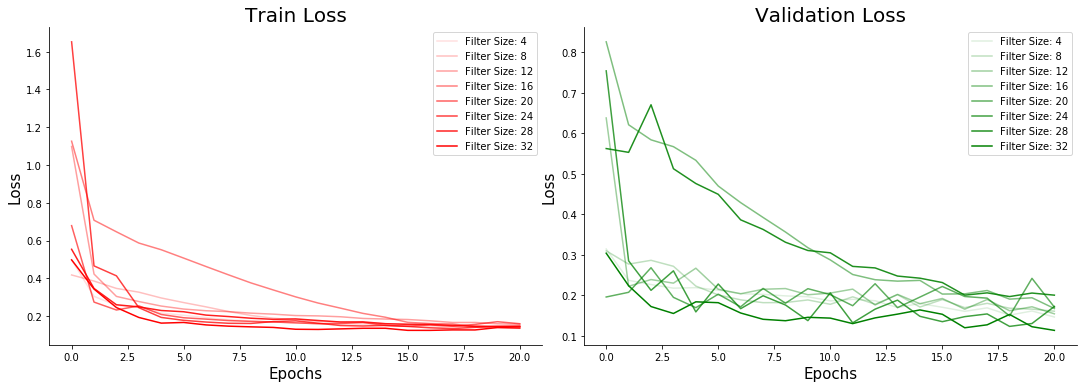

In [28]:
hw2.compare_conv_kernelSize(
    batch_size=20,
    kernel_size=3,
    max_epoch=20
)

After choosing the best batch size and kernel size, we can look at the results of the 1D conv model:

CONV1D_numEpoch-60_kernelSize-3_batchSize-16_filterSize-20_epoch-23


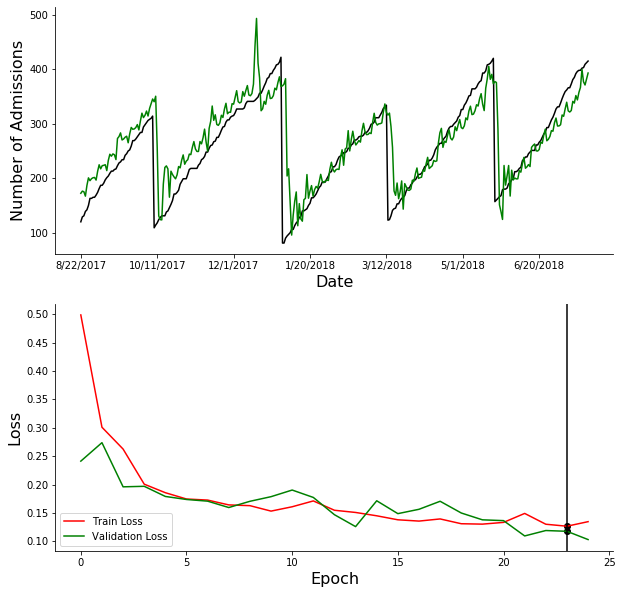

In [35]:
hw2.plot_conv(
    sc,
    norm_all_x,
    norm_all_y,
    dates,
    kernel_size=3,
    batch_size=16,
    filter_size=20,
    epoch=23
)

## Vector Autoregressions

For the third part of this problem, we are using Vector Autoregressions as our choice of model for the following reasons. 

1) We had initially worked with the regular Autoregression model, but realized that is mainly used for univariate time series data. Although we could use our initial dataset, which does not have any additional feature engineering, we figured using feature engineering would provide us with more accurate results, and better insights into our dataset. 

2) Vector Autoregressions are very useful for forecasting time series data because they consider moving averages when forecasting. As you can see from our data analysis, we have consistent moving averages, with highs and lows through the year in the number of daily admissions. 

In [56]:
from statsmodels.tsa.api import VAR

We need to remove the InquiryDate as a variable since we cannot use datetime type as a variable when using the VAR model

In [72]:
df_v = df[['DailyAdmission', 'Month', 'Day', 'Year', 'DayOfWeek', 'WeekNumber', 'Season', 'WeeksAfterPeak']]

In [73]:
df_v.head()

,DailyAdmission,Month,Day,Year,DayOfWeek,WeekNumber,Season,WeeksAfterPeak
7,77,8,29,2017,1,35,3.0,0.0
8,86,8,30,2017,2,35,3.0,0.0
9,92,8,31,2017,3,35,3.0,0.0
10,94,9,1,2017,4,35,3.0,0.0
11,94,9,2,2017,5,35,3.0,0.0


In [74]:
model = VAR(df_v.astype(float))

/Users/tnorlund/Library/Python/3.6/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [83]:
results = model.fit(2)
# results.summary()

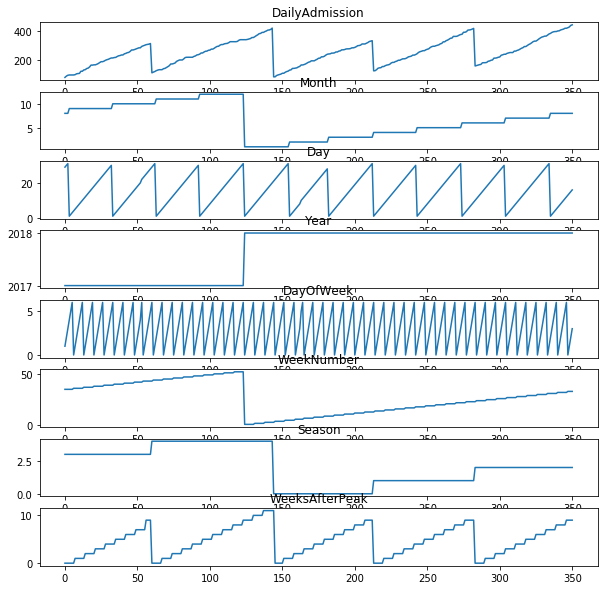

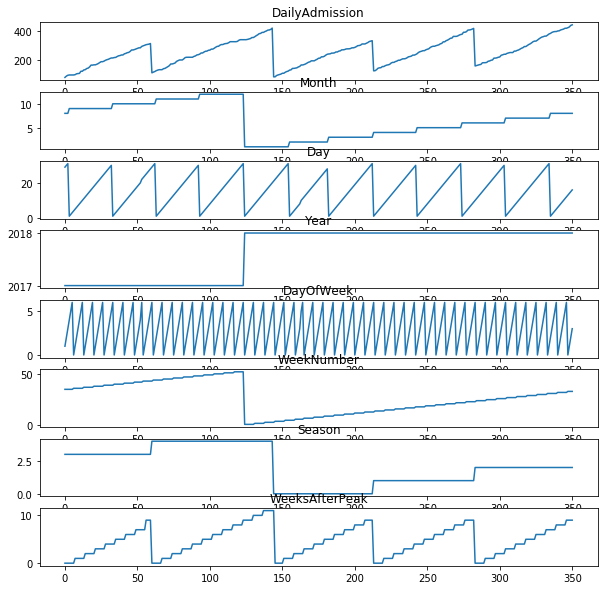

In [76]:
results.plot()

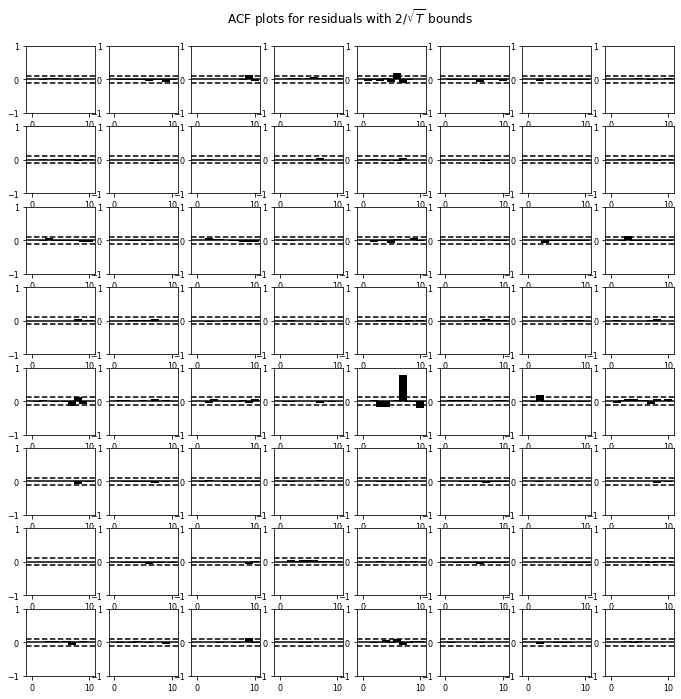

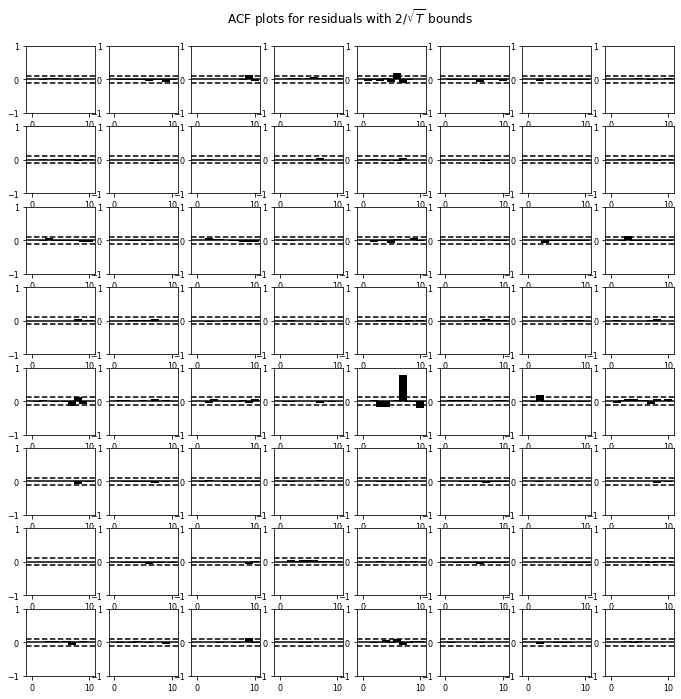

In [77]:
results.plot_acorr()

In [78]:
model.select_order(7)

In [79]:
results = model.fit(maxlags = 7, ic = 'aic')

In [80]:
lag_order = results.k_ar

In [81]:
results.forecast(df_v.values[-lag_order:], 5)

array([[4.48111373e+02, 7.96831530e+00, 1.51258221e+01, 2.01800786e+03,
        4.05777470e+00, 3.25864120e+01, 2.01243257e+00, 9.07481148e+00],
       [4.52954941e+02, 7.84542003e+00, 1.59728459e+01, 2.01801859e+03,
        5.02890631e+00, 3.20352677e+01, 2.02118463e+00, 9.08949874e+00],
       [4.30263418e+02, 7.78624870e+00, 1.50893776e+01, 2.01802875e+03,
        5.74101133e+00, 3.15475813e+01, 2.00587243e+00, 9.17487713e+00],
       [4.29754006e+02, 7.47032186e+00, 1.56180769e+01, 2.01805640e+03,
        5.06956622e-02, 3.10654569e+01, 2.02032011e+00, 8.95292556e+00],
       [4.27773298e+02, 7.40449787e+00, 1.61438527e+01, 2.01806324e+03,
        1.05005617e+00, 3.07103816e+01, 2.04410570e+00, 8.83179352e+00]])

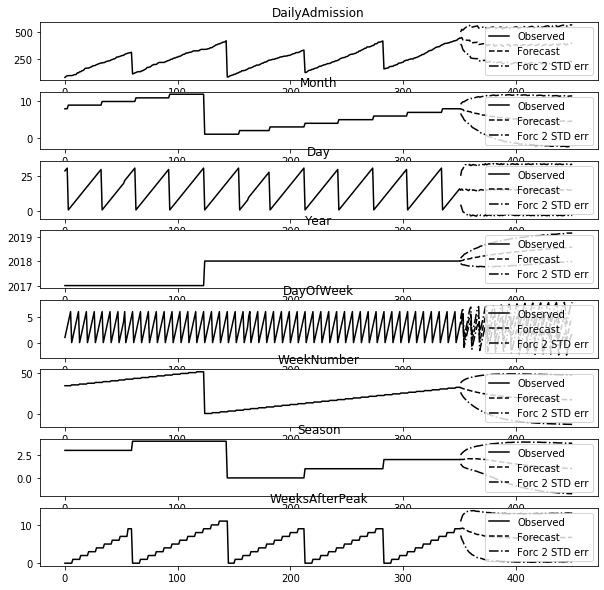

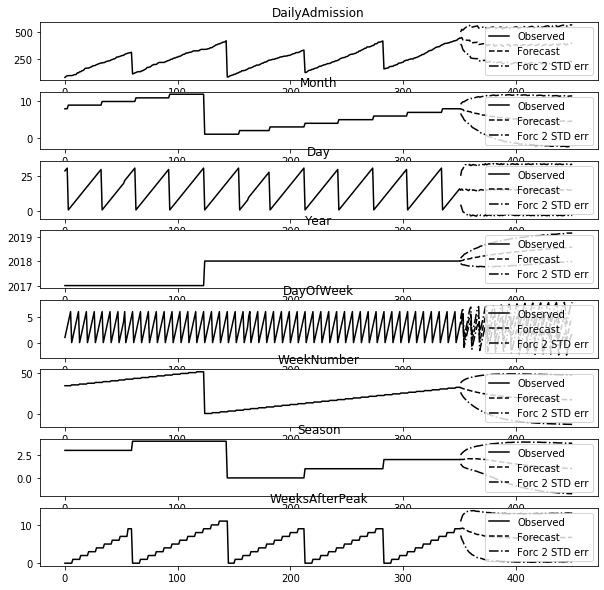

In [82]:
results.plot_forecast(100)

## Making Your Own Predictions

You can make your own predictions with you own dataset by using the following function. You must give it the name of the file with the name of the column that holds date. 

We are choosing the 1D Convolution model as our best model.

In [ ]:
norm_x, norm_y = process_csv(
    file_name="FILE NAME HERE", 
    date_column="DATETIME COLUMN NAME HERE" 
    sc
)
dates = df["DATETIME COLUMN NAME HERE"].tolist()
plot_conv(
    sc,
    norm_x,
    norm_y,
    dates,
    kernel_size=3,
    batch_size=16,
    filter_size=20,
    epoch=23
)